In [1]:
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd 
import cv2 as cv
import matplotlib.pyplot as plt
import os
import shutil
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid, save_image
import torchvision.transforms.functional as F
import torch.nn as nn
import torch


In [2]:
def isWhiteBG(img_path):
    img = Image.open(img_path).convert("L")  
    arr = np.array(img)
    h,w = arr.shape
    corners = [ int(arr[0, 0]), int(arr[0, w-1]), int(arr[h-1, 0]), int(arr[h-1, w-1])  ]

    inten = np.mean(corners)
    return inten>127

In [3]:
#Dataset Class
class PokeData(Dataset):
    def __init__(self,root_dir,transform1=None, transform2=None):
        self.root_dir = root_dir
        self.transform1 = transform1
        self.transform2 = transform2
        self.countWhite = 0
        
        img_whites = []
        img_blacks = []
        
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if isWhiteBG(os.path.join(root, file)):
                        img_whites.append(os.path.join(root, file))
                        self.countWhite+=1
                    else:
                        img_blacks.append(os.path.join(root, file))
        
        self.img_paths = img_whites + img_blacks           
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = Image.open(self.img_paths[index]).convert("RGB")
        if index<self.countWhite:
            if self.transform1:
                img = self.transform1(img)
        else:
            if self.transform2:
                img = self.transform2(img)
            
        return img

In [4]:
#Defining Dataset and Dataloader
transform1 = transforms.Compose([
    transforms.Resize((64, 64)),            
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))     
])

transform2 = transforms.Compose([
    transforms.Resize((64, 64)),            
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),
    F.invert,
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))     
])

root_dir = "/kaggle/input/complete-pokemon-library-32k-images-and-csv/Pokemon Dataset/Pokemon Dataset"

dataset = PokeData(root_dir, transform1=transform1, transform2 = transform2)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
#Discriminator Block
class Discriminator(nn.Module):
    def __init__(self, img_dim=64):
        super(Discriminator,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, img_dim, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_dim, img_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_dim*2, img_dim*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_dim*4, img_dim*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_dim*8, 1, 4, 2, 0, bias=False),
            nn.Sigmoid()    
        )

    def forward(self, inp):
        return self.model(inp)

In [6]:
#Generator Block
class Generator(nn.Module):
    def __init__(self,inp_dim=128,img_dim=64):
        super(Generator,self).__init__()
        self.model=nn.Sequential(
            nn.ConvTranspose2d(inp_dim, img_dim*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(img_dim*16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(img_dim*16, img_dim*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(img_dim*8, img_dim*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(img_dim*4, img_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(img_dim*2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, inp):
        return self.model(inp)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

loss = nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))


dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [9]:
generator

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Con

In [10]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)

Epoch [1/250]                        Batch 100/421 Discriminator Loss: 0.5909 Generator Loss: 2.3926
Epoch [1/250]                        Batch 200/421 Discriminator Loss: 0.9801 Generator Loss: 1.3020
Epoch [1/250]                        Batch 300/421 Discriminator Loss: 0.7682 Generator Loss: 3.7000
Epoch [1/250]                        Batch 400/421 Discriminator Loss: 0.5008 Generator Loss: 3.1066
Epoch [2/250]                        Batch 100/421 Discriminator Loss: 0.8109 Generator Loss: 4.2027
Epoch [2/250]                        Batch 200/421 Discriminator Loss: 1.0451 Generator Loss: 4.1851
Epoch [2/250]                        Batch 300/421 Discriminator Loss: 0.2399 Generator Loss: 4.0948
Epoch [2/250]                        Batch 400/421 Discriminator Loss: 0.1755 Generator Loss: 3.1629
Epoch [3/250]                        Batch 100/421 Discriminator Loss: 0.1210 Generator Loss: 4.8817
Epoch [3/250]                        Batch 200/421 Discriminator Loss: 0.3049 Generator Los

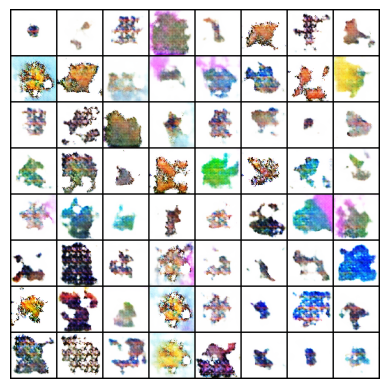

Saved sample images at epoch 10
Epoch [11/250]                        Batch 100/421 Discriminator Loss: 0.6768 Generator Loss: 12.9830
Epoch [11/250]                        Batch 200/421 Discriminator Loss: 0.0486 Generator Loss: 11.4566
Epoch [11/250]                        Batch 300/421 Discriminator Loss: 0.0510 Generator Loss: 3.6057
Epoch [11/250]                        Batch 400/421 Discriminator Loss: 0.3665 Generator Loss: 2.6252
Epoch [12/250]                        Batch 100/421 Discriminator Loss: 1.3241 Generator Loss: 0.0823
Epoch [12/250]                        Batch 200/421 Discriminator Loss: 1.2099 Generator Loss: 8.6678
Epoch [12/250]                        Batch 300/421 Discriminator Loss: 0.1215 Generator Loss: 5.2620
Epoch [12/250]                        Batch 400/421 Discriminator Loss: 0.0280 Generator Loss: 5.7047
Epoch [13/250]                        Batch 100/421 Discriminator Loss: 0.1280 Generator Loss: 3.5761
Epoch [13/250]                        Batch 200/

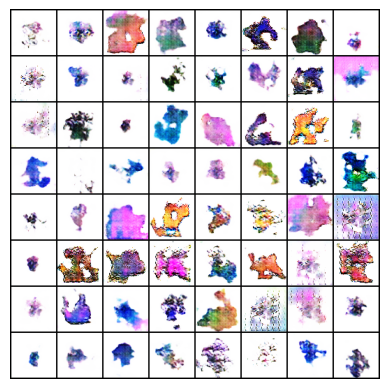

Saved sample images at epoch 20
Epoch [21/250]                        Batch 100/421 Discriminator Loss: 0.0440 Generator Loss: 9.9549
Epoch [21/250]                        Batch 200/421 Discriminator Loss: 0.0313 Generator Loss: 5.3914
Epoch [21/250]                        Batch 300/421 Discriminator Loss: 0.0833 Generator Loss: 6.1110
Epoch [21/250]                        Batch 400/421 Discriminator Loss: 0.0341 Generator Loss: 5.4661
Epoch [22/250]                        Batch 100/421 Discriminator Loss: 0.9933 Generator Loss: 11.8863
Epoch [22/250]                        Batch 200/421 Discriminator Loss: 0.0597 Generator Loss: 6.0947
Epoch [22/250]                        Batch 300/421 Discriminator Loss: 0.0566 Generator Loss: 5.4041
Epoch [22/250]                        Batch 400/421 Discriminator Loss: 1.5825 Generator Loss: 12.1607
Epoch [23/250]                        Batch 100/421 Discriminator Loss: 0.1379 Generator Loss: 7.9432
Epoch [23/250]                        Batch 200/

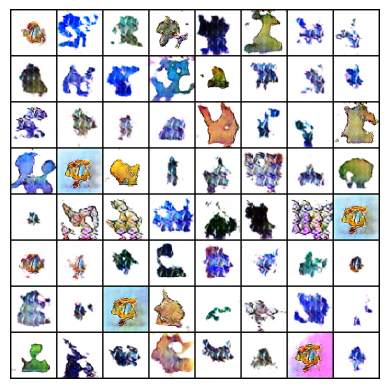

Saved sample images at epoch 30
Epoch [31/250]                        Batch 100/421 Discriminator Loss: 0.0235 Generator Loss: 6.4800
Epoch [31/250]                        Batch 200/421 Discriminator Loss: 0.1845 Generator Loss: 8.5186
Epoch [31/250]                        Batch 300/421 Discriminator Loss: 0.0594 Generator Loss: 5.9852
Epoch [31/250]                        Batch 400/421 Discriminator Loss: 0.1401 Generator Loss: 5.1849
Epoch [32/250]                        Batch 100/421 Discriminator Loss: 0.0277 Generator Loss: 6.4753
Epoch [32/250]                        Batch 200/421 Discriminator Loss: 0.0223 Generator Loss: 7.1177
Epoch [32/250]                        Batch 300/421 Discriminator Loss: 0.2790 Generator Loss: 11.9287
Epoch [32/250]                        Batch 400/421 Discriminator Loss: 0.1125 Generator Loss: 10.3381
Epoch [33/250]                        Batch 100/421 Discriminator Loss: 1.1036 Generator Loss: 18.1352
Epoch [33/250]                        Batch 200

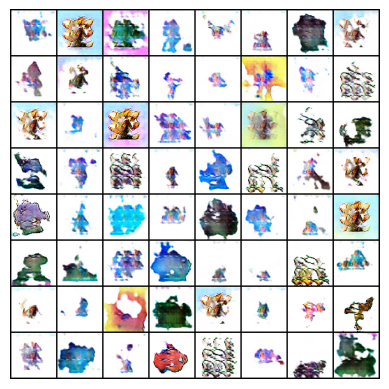

Saved sample images at epoch 40
Epoch [41/250]                        Batch 100/421 Discriminator Loss: 0.0329 Generator Loss: 6.2900
Epoch [41/250]                        Batch 200/421 Discriminator Loss: 0.0047 Generator Loss: 9.3986
Epoch [41/250]                        Batch 300/421 Discriminator Loss: 0.1750 Generator Loss: 6.8163
Epoch [41/250]                        Batch 400/421 Discriminator Loss: 0.0745 Generator Loss: 6.1526
Epoch [42/250]                        Batch 100/421 Discriminator Loss: 0.0155 Generator Loss: 6.3690
Epoch [42/250]                        Batch 200/421 Discriminator Loss: 0.0122 Generator Loss: 6.1418
Epoch [42/250]                        Batch 300/421 Discriminator Loss: 0.0489 Generator Loss: 8.6951
Epoch [42/250]                        Batch 400/421 Discriminator Loss: 0.0075 Generator Loss: 9.5486
Epoch [43/250]                        Batch 100/421 Discriminator Loss: 0.0135 Generator Loss: 5.8194
Epoch [43/250]                        Batch 200/42

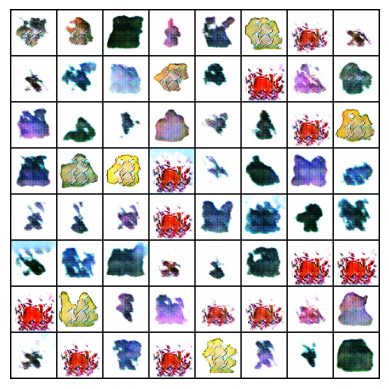

Saved sample images at epoch 50
Epoch [51/250]                        Batch 100/421 Discriminator Loss: 0.1612 Generator Loss: 8.4772
Epoch [51/250]                        Batch 200/421 Discriminator Loss: 0.0072 Generator Loss: 7.0897
Epoch [51/250]                        Batch 300/421 Discriminator Loss: 0.0035 Generator Loss: 6.7023
Epoch [51/250]                        Batch 400/421 Discriminator Loss: 0.0233 Generator Loss: 8.7530
Epoch [52/250]                        Batch 100/421 Discriminator Loss: 0.1080 Generator Loss: 6.4013
Epoch [52/250]                        Batch 200/421 Discriminator Loss: 0.0024 Generator Loss: 15.5463
Epoch [52/250]                        Batch 300/421 Discriminator Loss: 0.5683 Generator Loss: 17.8935
Epoch [52/250]                        Batch 400/421 Discriminator Loss: 0.0229 Generator Loss: 16.4566
Epoch [53/250]                        Batch 100/421 Discriminator Loss: 0.1859 Generator Loss: 7.4742
Epoch [53/250]                        Batch 200

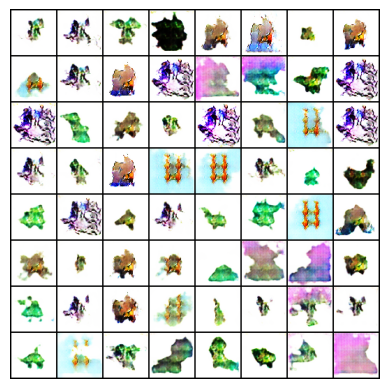

Saved sample images at epoch 60
Epoch [61/250]                        Batch 100/421 Discriminator Loss: 0.0022 Generator Loss: 9.7584
Epoch [61/250]                        Batch 200/421 Discriminator Loss: 0.0002 Generator Loss: 12.3752
Epoch [61/250]                        Batch 300/421 Discriminator Loss: 0.0207 Generator Loss: 5.8968
Epoch [61/250]                        Batch 400/421 Discriminator Loss: 0.5348 Generator Loss: 3.6279
Epoch [62/250]                        Batch 100/421 Discriminator Loss: 0.0114 Generator Loss: 5.7356
Epoch [62/250]                        Batch 200/421 Discriminator Loss: 0.0107 Generator Loss: 9.6823
Epoch [62/250]                        Batch 300/421 Discriminator Loss: 0.0662 Generator Loss: 10.7506
Epoch [62/250]                        Batch 400/421 Discriminator Loss: 0.0505 Generator Loss: 7.0352
Epoch [63/250]                        Batch 100/421 Discriminator Loss: 0.0188 Generator Loss: 5.7747
Epoch [63/250]                        Batch 200/

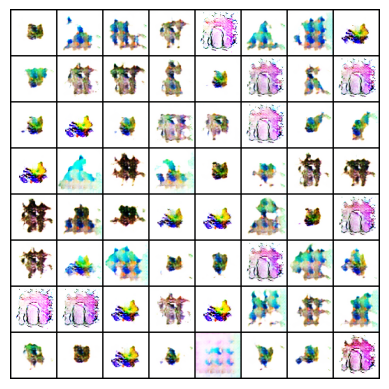

Saved sample images at epoch 70
Epoch [71/250]                        Batch 100/421 Discriminator Loss: 0.0010 Generator Loss: 7.2458
Epoch [71/250]                        Batch 200/421 Discriminator Loss: 0.1033 Generator Loss: 11.8896
Epoch [71/250]                        Batch 300/421 Discriminator Loss: 0.2612 Generator Loss: 2.9904
Epoch [71/250]                        Batch 400/421 Discriminator Loss: 0.0004 Generator Loss: 13.1467
Epoch [72/250]                        Batch 100/421 Discriminator Loss: 0.0743 Generator Loss: 10.2750
Epoch [72/250]                        Batch 200/421 Discriminator Loss: 0.0308 Generator Loss: 5.6357
Epoch [72/250]                        Batch 300/421 Discriminator Loss: 0.1174 Generator Loss: 8.3869
Epoch [72/250]                        Batch 400/421 Discriminator Loss: 0.0005 Generator Loss: 13.4993
Epoch [73/250]                        Batch 100/421 Discriminator Loss: 0.0188 Generator Loss: 3.2793
Epoch [73/250]                        Batch 20

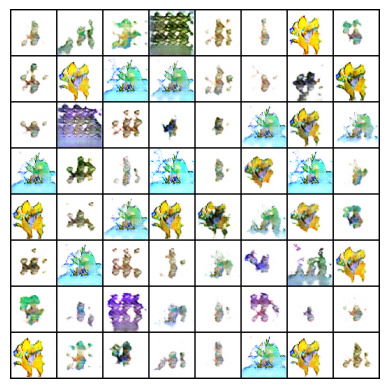

Saved sample images at epoch 80
Epoch [81/250]                        Batch 100/421 Discriminator Loss: 0.0950 Generator Loss: 4.1754
Epoch [81/250]                        Batch 200/421 Discriminator Loss: 0.0040 Generator Loss: 10.0873
Epoch [81/250]                        Batch 300/421 Discriminator Loss: 0.0863 Generator Loss: 4.3073
Epoch [81/250]                        Batch 400/421 Discriminator Loss: 0.1033 Generator Loss: 9.5849
Epoch [82/250]                        Batch 100/421 Discriminator Loss: 0.0169 Generator Loss: 6.5525
Epoch [82/250]                        Batch 200/421 Discriminator Loss: 0.0135 Generator Loss: 7.0837
Epoch [82/250]                        Batch 300/421 Discriminator Loss: 0.0047 Generator Loss: 7.6917
Epoch [82/250]                        Batch 400/421 Discriminator Loss: 0.0042 Generator Loss: 6.4218
Epoch [83/250]                        Batch 100/421 Discriminator Loss: 0.0125 Generator Loss: 6.6085
Epoch [83/250]                        Batch 200/4

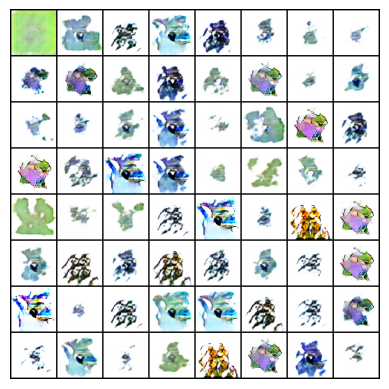

Saved sample images at epoch 90
Epoch [91/250]                        Batch 100/421 Discriminator Loss: 0.0033 Generator Loss: 7.0753
Epoch [91/250]                        Batch 200/421 Discriminator Loss: 0.0643 Generator Loss: 5.7480
Epoch [91/250]                        Batch 300/421 Discriminator Loss: 0.0134 Generator Loss: 6.0673
Epoch [91/250]                        Batch 400/421 Discriminator Loss: 0.0004 Generator Loss: 13.8961
Epoch [92/250]                        Batch 100/421 Discriminator Loss: 0.0076 Generator Loss: 6.8318
Epoch [92/250]                        Batch 200/421 Discriminator Loss: 0.0001 Generator Loss: 13.3181
Epoch [92/250]                        Batch 300/421 Discriminator Loss: 0.0077 Generator Loss: 5.9727
Epoch [92/250]                        Batch 400/421 Discriminator Loss: 0.0475 Generator Loss: 5.4348
Epoch [93/250]                        Batch 100/421 Discriminator Loss: 0.0063 Generator Loss: 8.0270
Epoch [93/250]                        Batch 200/

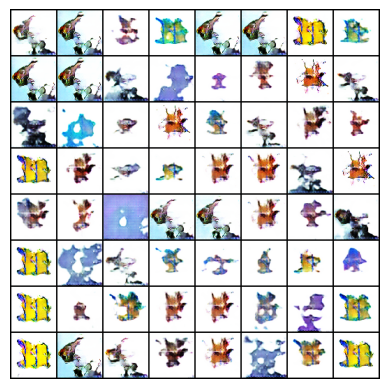

Saved sample images at epoch 100
Epoch [101/250]                        Batch 100/421 Discriminator Loss: 0.0057 Generator Loss: 5.9910
Epoch [101/250]                        Batch 200/421 Discriminator Loss: 0.0124 Generator Loss: 5.2624
Epoch [101/250]                        Batch 300/421 Discriminator Loss: 0.0029 Generator Loss: 10.1561
Epoch [101/250]                        Batch 400/421 Discriminator Loss: 0.3945 Generator Loss: 8.7406
Epoch [102/250]                        Batch 100/421 Discriminator Loss: 1.1522 Generator Loss: 1.2425
Epoch [102/250]                        Batch 200/421 Discriminator Loss: 0.0163 Generator Loss: 5.6761
Epoch [102/250]                        Batch 300/421 Discriminator Loss: 0.0383 Generator Loss: 5.6673
Epoch [102/250]                        Batch 400/421 Discriminator Loss: 0.0017 Generator Loss: 9.1091
Epoch [103/250]                        Batch 100/421 Discriminator Loss: 0.2075 Generator Loss: 5.7599
Epoch [103/250]                        

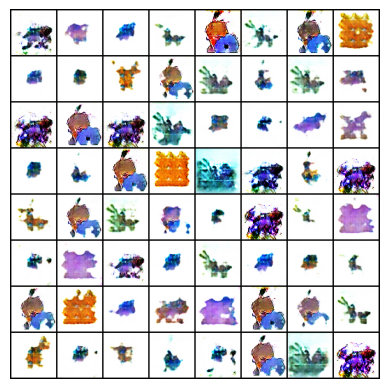

Saved sample images at epoch 110
Epoch [111/250]                        Batch 100/421 Discriminator Loss: 0.0002 Generator Loss: 10.6292
Epoch [111/250]                        Batch 200/421 Discriminator Loss: 0.0144 Generator Loss: 6.3425
Epoch [111/250]                        Batch 300/421 Discriminator Loss: 0.0039 Generator Loss: 7.0968
Epoch [111/250]                        Batch 400/421 Discriminator Loss: 0.0212 Generator Loss: 12.9790
Epoch [112/250]                        Batch 100/421 Discriminator Loss: 0.0120 Generator Loss: 5.9885
Epoch [112/250]                        Batch 200/421 Discriminator Loss: 0.0026 Generator Loss: 10.3721
Epoch [112/250]                        Batch 300/421 Discriminator Loss: 0.0029 Generator Loss: 6.2204
Epoch [112/250]                        Batch 400/421 Discriminator Loss: 0.0249 Generator Loss: 6.8101
Epoch [113/250]                        Batch 100/421 Discriminator Loss: 0.0051 Generator Loss: 10.1070
Epoch [113/250]                     

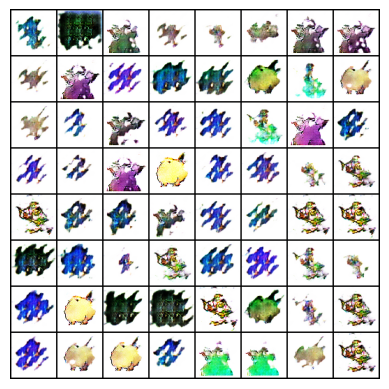

Saved sample images at epoch 120
Epoch [121/250]                        Batch 100/421 Discriminator Loss: 0.0005 Generator Loss: 13.5729
Epoch [121/250]                        Batch 200/421 Discriminator Loss: 0.0058 Generator Loss: 6.3224
Epoch [121/250]                        Batch 300/421 Discriminator Loss: 0.0015 Generator Loss: 8.4949
Epoch [121/250]                        Batch 400/421 Discriminator Loss: 0.0004 Generator Loss: 9.5669
Epoch [122/250]                        Batch 100/421 Discriminator Loss: 0.0071 Generator Loss: 7.8689
Epoch [122/250]                        Batch 200/421 Discriminator Loss: 0.0045 Generator Loss: 5.5449
Epoch [122/250]                        Batch 300/421 Discriminator Loss: 0.0037 Generator Loss: 19.6908
Epoch [122/250]                        Batch 400/421 Discriminator Loss: 0.0028 Generator Loss: 7.2433
Epoch [123/250]                        Batch 100/421 Discriminator Loss: 0.0008 Generator Loss: 11.4942
Epoch [123/250]                      

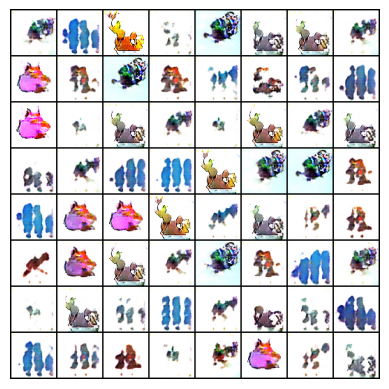

Saved sample images at epoch 130
Epoch [131/250]                        Batch 100/421 Discriminator Loss: 0.0022 Generator Loss: 6.6991
Epoch [131/250]                        Batch 200/421 Discriminator Loss: 0.0227 Generator Loss: 7.4423
Epoch [131/250]                        Batch 300/421 Discriminator Loss: 0.0219 Generator Loss: 5.9011
Epoch [131/250]                        Batch 400/421 Discriminator Loss: 0.1033 Generator Loss: 4.0674
Epoch [132/250]                        Batch 100/421 Discriminator Loss: 0.0033 Generator Loss: 8.2266
Epoch [132/250]                        Batch 200/421 Discriminator Loss: 0.0127 Generator Loss: 6.8870
Epoch [132/250]                        Batch 300/421 Discriminator Loss: 0.0099 Generator Loss: 7.7305
Epoch [132/250]                        Batch 400/421 Discriminator Loss: 0.3021 Generator Loss: 4.2791
Epoch [133/250]                        Batch 100/421 Discriminator Loss: 0.0030 Generator Loss: 9.6114
Epoch [133/250]                        B

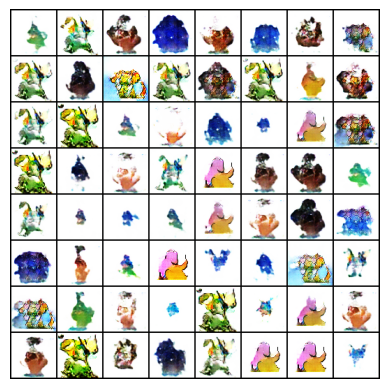

Saved sample images at epoch 140
Epoch [141/250]                        Batch 100/421 Discriminator Loss: 0.2726 Generator Loss: 1.6763
Epoch [141/250]                        Batch 200/421 Discriminator Loss: 0.0275 Generator Loss: 6.7921
Epoch [141/250]                        Batch 300/421 Discriminator Loss: 0.0424 Generator Loss: 5.4858
Epoch [141/250]                        Batch 400/421 Discriminator Loss: 0.0017 Generator Loss: 6.9245
Epoch [142/250]                        Batch 100/421 Discriminator Loss: 0.0147 Generator Loss: 5.5796
Epoch [142/250]                        Batch 200/421 Discriminator Loss: 0.0006 Generator Loss: 9.2083
Epoch [142/250]                        Batch 300/421 Discriminator Loss: 0.0244 Generator Loss: 7.7479
Epoch [142/250]                        Batch 400/421 Discriminator Loss: 0.0024 Generator Loss: 6.5848
Epoch [143/250]                        Batch 100/421 Discriminator Loss: 0.0067 Generator Loss: 8.0835
Epoch [143/250]                        B

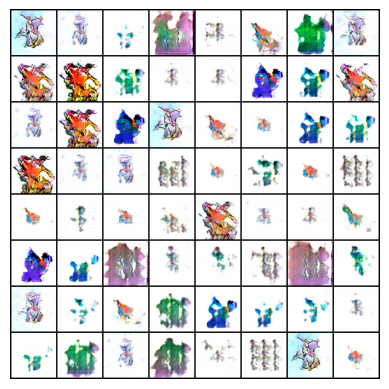

Saved sample images at epoch 150
Epoch [151/250]                        Batch 100/421 Discriminator Loss: 0.0006 Generator Loss: 9.5698
Epoch [151/250]                        Batch 200/421 Discriminator Loss: 0.0235 Generator Loss: 6.1558
Epoch [151/250]                        Batch 300/421 Discriminator Loss: 0.1982 Generator Loss: 9.0997
Epoch [151/250]                        Batch 400/421 Discriminator Loss: 0.0038 Generator Loss: 14.7954
Epoch [152/250]                        Batch 100/421 Discriminator Loss: 0.0029 Generator Loss: 6.5901
Epoch [152/250]                        Batch 200/421 Discriminator Loss: 0.0076 Generator Loss: 6.2607
Epoch [152/250]                        Batch 300/421 Discriminator Loss: 0.4037 Generator Loss: 11.2868
Epoch [152/250]                        Batch 400/421 Discriminator Loss: 0.0050 Generator Loss: 5.6708
Epoch [153/250]                        Batch 100/421 Discriminator Loss: 0.0126 Generator Loss: 5.3669
Epoch [153/250]                       

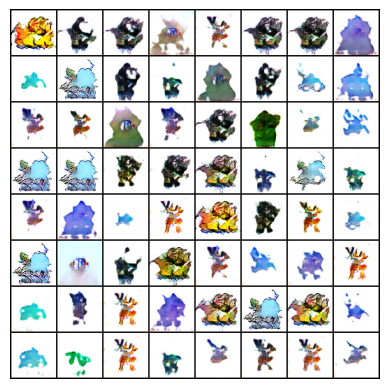

Saved sample images at epoch 160
Epoch [161/250]                        Batch 100/421 Discriminator Loss: 0.0027 Generator Loss: 6.1045
Epoch [161/250]                        Batch 200/421 Discriminator Loss: 0.0007 Generator Loss: 14.0035
Epoch [161/250]                        Batch 300/421 Discriminator Loss: 0.0050 Generator Loss: 7.6424
Epoch [161/250]                        Batch 400/421 Discriminator Loss: 0.0040 Generator Loss: 10.3399
Epoch [162/250]                        Batch 100/421 Discriminator Loss: 0.0052 Generator Loss: 5.8132
Epoch [162/250]                        Batch 200/421 Discriminator Loss: 0.0023 Generator Loss: 6.7214
Epoch [162/250]                        Batch 300/421 Discriminator Loss: 0.0171 Generator Loss: 6.3571
Epoch [162/250]                        Batch 400/421 Discriminator Loss: 0.0010 Generator Loss: 7.0904
Epoch [163/250]                        Batch 100/421 Discriminator Loss: 0.0011 Generator Loss: 9.3544
Epoch [163/250]                       

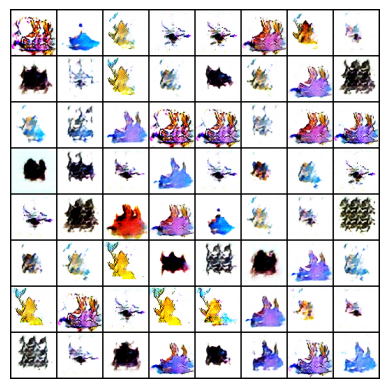

Saved sample images at epoch 170
Epoch [171/250]                        Batch 100/421 Discriminator Loss: 0.0153 Generator Loss: 6.4354
Epoch [171/250]                        Batch 200/421 Discriminator Loss: 0.0055 Generator Loss: 6.7058
Epoch [171/250]                        Batch 300/421 Discriminator Loss: 0.0085 Generator Loss: 6.0057
Epoch [171/250]                        Batch 400/421 Discriminator Loss: 0.0055 Generator Loss: 6.4090
Epoch [172/250]                        Batch 100/421 Discriminator Loss: 0.1156 Generator Loss: 8.1203
Epoch [172/250]                        Batch 200/421 Discriminator Loss: 0.0083 Generator Loss: 5.9702
Epoch [172/250]                        Batch 300/421 Discriminator Loss: 0.0001 Generator Loss: 11.4281
Epoch [172/250]                        Batch 400/421 Discriminator Loss: 0.0029 Generator Loss: 6.7534
Epoch [173/250]                        Batch 100/421 Discriminator Loss: 0.0006 Generator Loss: 9.9997
Epoch [173/250]                        

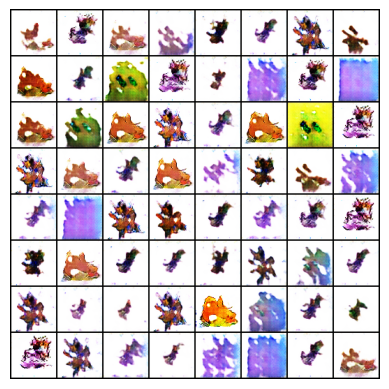

Saved sample images at epoch 180
Epoch [181/250]                        Batch 100/421 Discriminator Loss: 0.0014 Generator Loss: 8.1194
Epoch [181/250]                        Batch 200/421 Discriminator Loss: 0.0258 Generator Loss: 5.1893
Epoch [181/250]                        Batch 300/421 Discriminator Loss: 0.0767 Generator Loss: 4.7325
Epoch [181/250]                        Batch 400/421 Discriminator Loss: 0.0064 Generator Loss: 5.5852
Epoch [182/250]                        Batch 100/421 Discriminator Loss: 0.0027 Generator Loss: 7.0634
Epoch [182/250]                        Batch 200/421 Discriminator Loss: 0.0141 Generator Loss: 8.0944
Epoch [182/250]                        Batch 300/421 Discriminator Loss: 0.0014 Generator Loss: 7.0066
Epoch [182/250]                        Batch 400/421 Discriminator Loss: 0.0024 Generator Loss: 7.5529
Epoch [183/250]                        Batch 100/421 Discriminator Loss: 0.0028 Generator Loss: 6.3745
Epoch [183/250]                        B

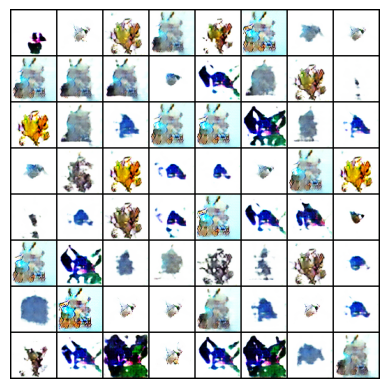

Saved sample images at epoch 190
Epoch [191/250]                        Batch 100/421 Discriminator Loss: 0.3095 Generator Loss: 9.9131
Epoch [191/250]                        Batch 200/421 Discriminator Loss: 0.0138 Generator Loss: 6.7928
Epoch [191/250]                        Batch 300/421 Discriminator Loss: 0.0029 Generator Loss: 8.1144
Epoch [191/250]                        Batch 400/421 Discriminator Loss: 0.0064 Generator Loss: 5.5744
Epoch [192/250]                        Batch 100/421 Discriminator Loss: 0.0066 Generator Loss: 6.3093
Epoch [192/250]                        Batch 200/421 Discriminator Loss: 0.0016 Generator Loss: 8.7956
Epoch [192/250]                        Batch 300/421 Discriminator Loss: 0.0166 Generator Loss: 5.5326
Epoch [192/250]                        Batch 400/421 Discriminator Loss: 0.0006 Generator Loss: 8.5955
Epoch [193/250]                        Batch 100/421 Discriminator Loss: 0.0001 Generator Loss: 13.7329
Epoch [193/250]                        

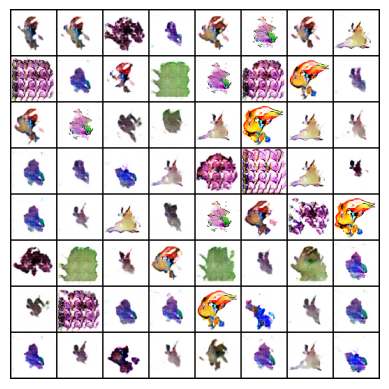

Saved sample images at epoch 200
Epoch [201/250]                        Batch 100/421 Discriminator Loss: 0.0007 Generator Loss: 10.2967
Epoch [201/250]                        Batch 200/421 Discriminator Loss: 0.0049 Generator Loss: 8.9034
Epoch [201/250]                        Batch 300/421 Discriminator Loss: 0.0021 Generator Loss: 7.5337
Epoch [201/250]                        Batch 400/421 Discriminator Loss: 0.0058 Generator Loss: 8.6649
Epoch [202/250]                        Batch 100/421 Discriminator Loss: 0.0083 Generator Loss: 7.5759
Epoch [202/250]                        Batch 200/421 Discriminator Loss: 0.0024 Generator Loss: 7.4096
Epoch [202/250]                        Batch 300/421 Discriminator Loss: 0.0016 Generator Loss: 8.8291
Epoch [202/250]                        Batch 400/421 Discriminator Loss: 0.0219 Generator Loss: 5.3451
Epoch [203/250]                        Batch 100/421 Discriminator Loss: 0.0077 Generator Loss: 5.2816
Epoch [203/250]                        

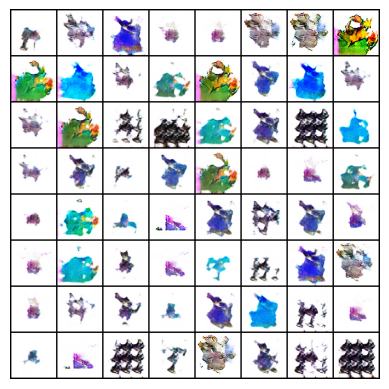

Saved sample images at epoch 210
Epoch [211/250]                        Batch 100/421 Discriminator Loss: 0.0031 Generator Loss: 6.1060
Epoch [211/250]                        Batch 200/421 Discriminator Loss: 0.0046 Generator Loss: 6.6379
Epoch [211/250]                        Batch 300/421 Discriminator Loss: 0.0110 Generator Loss: 5.7773
Epoch [211/250]                        Batch 400/421 Discriminator Loss: 0.0032 Generator Loss: 7.4204
Epoch [212/250]                        Batch 100/421 Discriminator Loss: 0.0864 Generator Loss: 4.7435
Epoch [212/250]                        Batch 200/421 Discriminator Loss: 0.3476 Generator Loss: 4.3092
Epoch [212/250]                        Batch 300/421 Discriminator Loss: 0.0002 Generator Loss: 16.3124
Epoch [212/250]                        Batch 400/421 Discriminator Loss: 0.0006 Generator Loss: 8.8809
Epoch [213/250]                        Batch 100/421 Discriminator Loss: 0.0069 Generator Loss: 6.0905
Epoch [213/250]                        

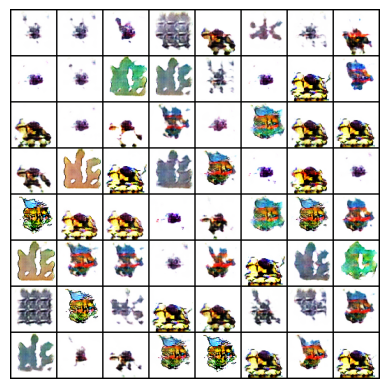

Saved sample images at epoch 220
Epoch [221/250]                        Batch 100/421 Discriminator Loss: 0.0001 Generator Loss: 10.8337
Epoch [221/250]                        Batch 200/421 Discriminator Loss: 0.0075 Generator Loss: 6.3461
Epoch [221/250]                        Batch 300/421 Discriminator Loss: 0.0010 Generator Loss: 8.0796
Epoch [221/250]                        Batch 400/421 Discriminator Loss: 0.0092 Generator Loss: 8.0331
Epoch [222/250]                        Batch 100/421 Discriminator Loss: 0.0399 Generator Loss: 5.7566
Epoch [222/250]                        Batch 200/421 Discriminator Loss: 0.0246 Generator Loss: 6.9846
Epoch [222/250]                        Batch 300/421 Discriminator Loss: 0.0786 Generator Loss: 6.9963
Epoch [222/250]                        Batch 400/421 Discriminator Loss: 0.0027 Generator Loss: 7.1953
Epoch [223/250]                        Batch 100/421 Discriminator Loss: 0.0156 Generator Loss: 6.9713
Epoch [223/250]                        

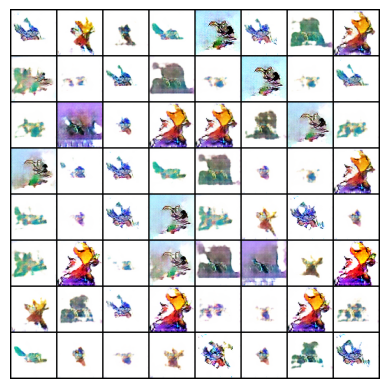

Saved sample images at epoch 230
Epoch [231/250]                        Batch 100/421 Discriminator Loss: 0.0002 Generator Loss: 10.2935
Epoch [231/250]                        Batch 200/421 Discriminator Loss: 0.0005 Generator Loss: 7.7123
Epoch [231/250]                        Batch 300/421 Discriminator Loss: 0.0089 Generator Loss: 6.6515
Epoch [231/250]                        Batch 400/421 Discriminator Loss: 0.0314 Generator Loss: 9.0889
Epoch [232/250]                        Batch 100/421 Discriminator Loss: 0.0035 Generator Loss: 6.9758
Epoch [232/250]                        Batch 200/421 Discriminator Loss: 0.0096 Generator Loss: 7.9348
Epoch [232/250]                        Batch 300/421 Discriminator Loss: 0.0031 Generator Loss: 7.8812
Epoch [232/250]                        Batch 400/421 Discriminator Loss: 0.0010 Generator Loss: 7.1721
Epoch [233/250]                        Batch 100/421 Discriminator Loss: 0.0006 Generator Loss: 15.0872
Epoch [233/250]                       

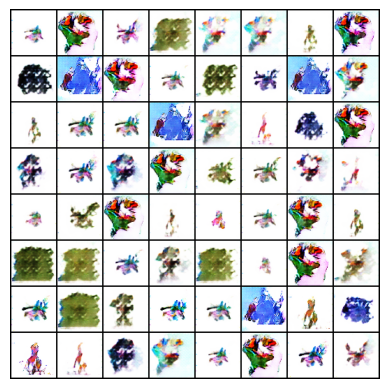

Saved sample images at epoch 240
Epoch [241/250]                        Batch 100/421 Discriminator Loss: 0.9183 Generator Loss: 10.8939
Epoch [241/250]                        Batch 200/421 Discriminator Loss: 0.0076 Generator Loss: 6.6084
Epoch [241/250]                        Batch 300/421 Discriminator Loss: 0.0014 Generator Loss: 7.9068
Epoch [241/250]                        Batch 400/421 Discriminator Loss: 0.0029 Generator Loss: 6.8302
Epoch [242/250]                        Batch 100/421 Discriminator Loss: 0.0001 Generator Loss: 9.6541
Epoch [242/250]                        Batch 200/421 Discriminator Loss: 0.0004 Generator Loss: 8.7229
Epoch [242/250]                        Batch 300/421 Discriminator Loss: 0.0033 Generator Loss: 7.8656
Epoch [242/250]                        Batch 400/421 Discriminator Loss: 0.0018 Generator Loss: 6.7216
Epoch [243/250]                        Batch 100/421 Discriminator Loss: 0.0116 Generator Loss: 5.3066
Epoch [243/250]                        

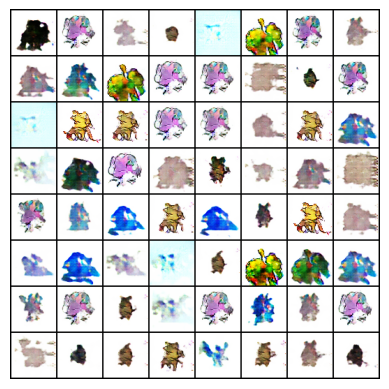

Saved sample images at epoch 250


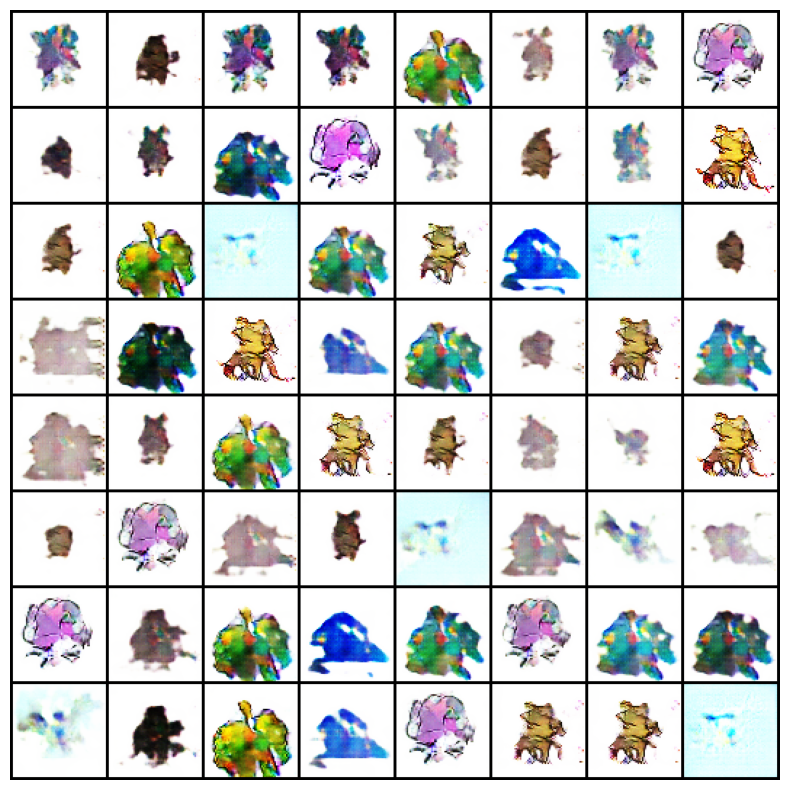

In [11]:
num_epochs = 250
z_dim=128
DLosses = []
GLosses = []
len_dl = len(dataloader)
for epoch in range(num_epochs):
    for i, real_imgs in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        b_size= real_imgs.size(0)
        noise = torch.randn(b_size, z_dim,1,1, device=device)
        fake_imgs = generator(noise)
        
        #Training Discriminator
        real_disc = discriminator(real_imgs).view(-1)
        DLoss_real = loss(real_disc,torch.ones_like(real_disc))
        
        fake_disc = discriminator(fake_imgs.detach()).view(-1)
        DLoss_fake = loss(fake_disc,torch.zeros_like(fake_disc))
        
        DLoss = (DLoss_real + DLoss_fake) / 2
        optimizer_D.zero_grad()
        DLoss.backward()
        optimizer_D.step()

        #Training Generator
        disc_output = discriminator(fake_imgs).view(-1)
        GLoss = loss(disc_output, torch.ones_like(disc_output))
        optimizer_G.zero_grad()
        GLoss.backward()
        optimizer_G.step()
        
        DLosses.append(DLoss.item())
        GLosses.append(GLoss.item())
        
        if (i + 1) %100==0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {DLoss.item():.4f} "
                f"Generator Loss: {GLoss.item():.4f}"
            )
            
        if (epoch + 1) % 10 == 0 and i+1==len(dataloader):
            with torch.no_grad():
                z = torch.randn(64, z_dim, 1,1,device=device)
                generated = generator(z).detach().cpu()
                grid = make_grid(generated, nrow=8, normalize=True)
                plt.imshow(np.transpose(grid, (1, 2, 0)))
                plt.axis("off")
                plt.show()


        if (epoch + 1) % 10 == 0 and i+1==len(dataloader):
            with torch.no_grad():
                fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)
                generated = generator(fixed_noise)
        
                save_image(generated, f"/kaggle/working/generated_epoch_{epoch+1}.png",nrow=8, normalize=True)
        
            print(f"Saved sample images at epoch {epoch+1}")
            
        if ((epoch+1)% 20 == 0 or epoch+1==num_epochs) and i+1==len(dataloader):
            torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'loss_G': GLoss,
            'loss_D': DLoss,
            }, f"/kaggle/working/gan_checkpoint_epoch_{epoch+1}.pth")

with torch.no_grad():
    z = torch.randn(64, z_dim, 1,1,device=device)
    generated = generator(z).detach().cpu()
    plt.figure(figsize=(10, 10))
    grid = make_grid(generated, nrow=8, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis("off")
    plt.show()

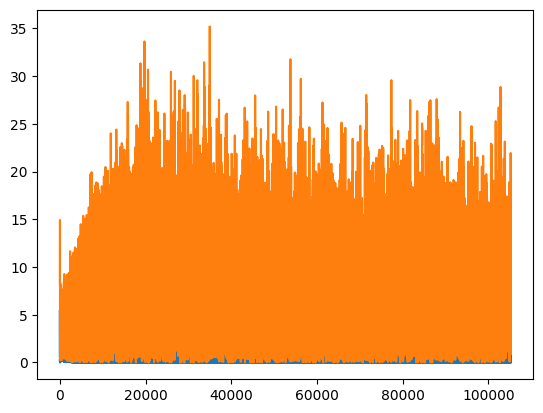

In [12]:
plt.plot(DLosses)
plt.plot(GLosses)
plt.show()